<a href="https://colab.research.google.com/github/zia207/r4ds-env-modeling/blob/main/NoteBook/Spatial_interpolation/universal_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Universal Kriging in R**

Zia Ahmed, Unversity Buffalo

Universal Kriging (UK) is an extension of traditional Kriging that allows for the incorporation of a trend or deterministic function into the spatial interpolation process. Unlike ordinary Kriging, which assumes a constant mean across the entire dataset, Universal Kriging accounts for the presence of a systematic trend in the data. This trend can be linear, quadratic, logarithmic, or any other functional form that represents the underlying spatial pattern.

Here's how Universal Kriging works:

1. **Data Preparation:**
   - You start with a dataset that includes measurements of a variable of interest at various spatial locations. Additionally, you have information about a trend or deterministic function that affects the variable's values across the study area.

2. **Trend Analysis:**
   - The first step in Universal Kriging is to analyze the trend in the data. This can be done through statistical methods or domain knowledge. The trend represents the systematic variation in the variable of interest that is not accounted for by spatial autocorrelation.

3. **Detrending:**
   - Subtract the trend component from the observed values to obtain detrended residuals. These residuals represent the spatially autocorrelated variation in the data after removing the deterministic trend.

4. **Variogram Analysis:**
   - Calculate and model the variogram of the detrended residuals. The variogram quantifies the spatial autocorrelation in the data, describing how the variance of the residuals changes with distance and direction.

5. **Universal Kriging Estimation:**
   - Universal Kriging estimates the variable of interest at unsampled locations by considering both the spatial autocorrelation (modeled through the variogram) and the trend information.
   - The estimation equation in Universal Kriging takes the form:

   Z(u)=μ(u)+∑λi[Z(xi)−μ(xi)]+T(u)

Where:

  * Z(u) is the estimated value at the unsampled location u.

  * μ(u) represents the local mean or trend value at location u.

  * i are the Kriging weights determined through variogram modeling.

  * (xi) is the observed value at location xi.

  * (xi) represents the local mean or trend value at location xi.

  * T(u) represents the trend value at location u, which is known or estimated


6. **Prediction Variance:**
   - Universal Kriging provides not only the estimated values but also prediction variances. The prediction variance quantifies the uncertainty associated with the predictions, considering both the spatial variability (accounted for by the variogram) and the uncertainty in the trend estimation.

Universal Kriging is particularly useful when there is a known or suspected trend in the data, such as elevation changes in topographic datasets or gradual variations in environmental variables. By incorporating both the spatial autocorrelation and the trend information, Universal Kriging provides more accurate and reliable estimates of the variable of interest across the study area.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314930 sha256=6f023ae572d5bf3a2e439cb1d6f49cb90921932fa6ee93aa7c762f39d95a3d0e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'tidymodels','raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot',
         'ggmap','ggpmisc', 'plyr','spatstat','dismo','fields', 'moments', 'car')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (tidymodels)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)
library(moments)
library(car)
library(ggpmisc)

### Data

The following data will be used in the exercise that can be found in my [Dropbox](https://www.dropbox.com/scl/fo/j7322sbo4gdqv8a2rfqry/h?rlkey=fmlnsu08lut4pxf0s4q1jm44a&dl=0) folder.

1. GP_all_data.csv

2. GP_prediction_grid_data.csv

In [4]:
%%R
mf<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_all_data.csv')
grid<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/GP_prediction_grid_data.csv')

Rows: 471 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Silt_Clay...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Data Transformation

First, we have to calculate appropriate transformation parameters using the **powerTransform()** function of the car package and then use this parameter to transform the data using the **bcPower()** function.

In [5]:
%%R
power<-powerTransform(mf$SOC)
lambda<-power$lambda
lambda

   mf$SOC 
0.2905371 


In [6]:
%%R
mf$SOC.bc<-bcPower(mf$SOC,lambda)

### Split data

In [7]:
%%R
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(mf, prop = 0.8, strata = SOC.bc)
train <- split %>% training()
test <-  split %>% testing()

In [8]:
%%R
df.xy<-mf %>% dplyr::select(x, y, SOC, SOC.bc)
train.xy<-train %>% dplyr::select(x, y, SOC, SOC.bc)
test.xy<-test %>% dplyr::select(x, y, SOC, SOC.bc)
grid.xy<-grid %>% dplyr::select(x,y)

### Define x & y variables to coordinates

In [9]:
%%R
coordinates(train.xy) = ~x+y
coordinates(test.xy) = ~x+y
coordinates(grid.xy) = ~x+y

## **Trend Analysis**

Trend Surface Analysis (TSA) is a deterministic method used for spatial interpolation and modeling. It is particularly useful when you want to capture and describe the broad, systematic trends or patterns in a set of data points distributed across a geographic area.

We will compute and visualize a first-order trend surface using the **krige()** function of the gstat package. First, we will fit a linear model using x and y coordinates as predictors.



In [10]:
%%R
trend.lm<-lm(SOC.bc~x+y, data=as.data.frame(train.xy))
summary(trend.lm)


Call:
lm(formula = SOC.bc ~ x + y, data = as.data.frame(train.xy))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3004 -0.7933 -0.0462  0.8452  4.1184 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.266e-01  3.540e-01   1.488  0.13773    
x           6.453e-07  1.959e-07   3.295  0.00108 ** 
y           1.107e-06  1.852e-07   5.977 5.33e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.282 on 372 degrees of freedom
Multiple R-squared:  0.1037,	Adjusted R-squared:  0.09887 
F-statistic: 21.52 on 2 and 372 DF,  p-value: 1.436e-09



It looks like x and y are significant, implying a significant trend of SOC in both the x and y directions. So have to detrend the data, or we have to use UK instead of OK.  

In [11]:
%%R
trend<-krige(SOC.bc~x+y, train.xy, grid.xy, model=NULL)
summary(trend)

[ordinary or weighted least squares prediction]
Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred         var1.var    
 Min.   :0.8405   Min.   :1.647  
 1st Qu.:1.6124   1st Qu.:1.650  
 Median :2.1003   Median :1.655  
 Mean   :1.9853   Mean   :1.656  
 3rd Qu.:2.3475   3rd Qu.:1.661  
 Max.   :2.8547   Max.   :1.681  


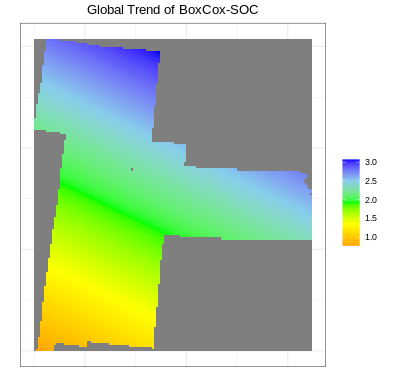

In [ ]:
%%R -w 400 -h 375 -u px
trend.r<-rasterFromXYZ(as.data.frame(trend)[, c("x", "y", "var1.pred")])
ggR(trend.r, geom_raster = TRUE) +
scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("Global Trend of BoxCox-SOC")+
   theme(plot.title = element_text(hjust = 0.5))

## **Variogram Modeling**

In the UK, the semivariances are derived from residuals, not from the original data, as the random element of the spatial structure is only applied to residuals. The residuals model parameters will typically differ significantly from the initial variogram model (usually: lower sill; shorter range) as the the global trend has taken out some of the variation.

In gstat, we can compute residual varoigram directly, if we provide an appropriate model formula; you do not have to compute the residuals manually.

We use the variogram method and specify the spatial dependence with the formula SOC.bc ~ x+y (as opposed to SOC.bc ~ 1 in the ordinary variogram). This has the same meaning as in the lm (linear regression) model specification: the SOC concentration is to be predicted using Ist order trend; then the residuals are to be modeled spatially.

### Original Variogram

In [12]:
%%R
# Short range structure
v.bc<-variogram(SOC.bc~ 1, data = train.xy, cloud=F)
# Add long range
vm.bc<-fit.variogram(v.bc, vgm(1, "Exp", 65000, add.to=vgm(0.5, "Exp", 2000)))
vm.bc

  model     psill     range
1   Exp 0.9585346  20784.69
2   Exp 0.8305824 123589.55


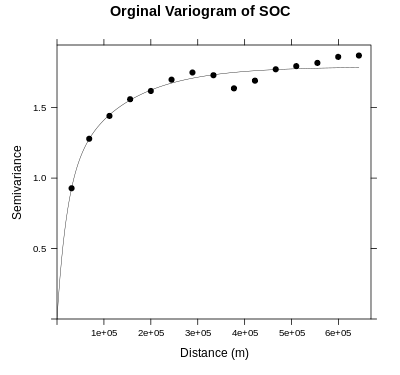

In [13]:
%%R -w 400 -h 375 -u px
# Plot varigram and fitted model:
plot(v.bc, pl=F,
     model=vm.bc,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Orginal Variogram of SOC",
     xlab="Distance (m)",
     ylab="Semivariance")


### Residual Varigram

In [14]:
%%R
# Short range structure
v.bc.r<-variogram(SOC.bc~ x+y, data = train.xy, cloud=F)
# Add long range
vm.bc.r<-fit.variogram(v.bc.r, vgm(1, "Exp", 65000, add.to=vgm(0.5, "Exp", 2000)))
vm.bc.r

  model     psill     range
1   Exp 0.9267618  19949.25
2   Exp 0.8570755 117997.77


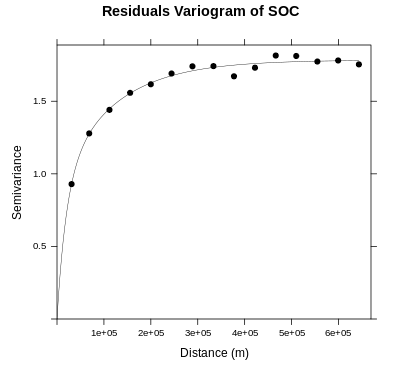

In [15]:
%%R -w 400 -h 375 -u px
# Plot varigram and fitted model:
plot(v.bc.r, pl=F,
     model=vm.bc.r,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Residuals Variogram of SOC",
     xlab="Distance (m)",
     ylab="Semivariance")

## **K-fold Cross Validation**


K-fold cross-validation is a widely used technique in machine learning and statistics to assess the performance and generalization of a predictive model. It involves dividing a dataset into K subsets or "folds," using K-1 folds for training and the remaining fold for testing. This process is repeated K times, with each fold serving as the test set once. K-fold cross-validation helps to provide a more reliable estimate of a model's performance and its ability to generalize to new, unseen data.

We will use **krige.cv()** to evaluate the model with k-fold cross validation. We will use formula SOC.bc ~ x+y as opposed to SOC.bc ~ 1 in the OK.

In [16]:
%%R
cv<-krige.cv(SOC.bc ~ x+y,
         train.xy,              # data
         model = vm.bc.r,      # fitted varigram model
         nfold=10)           # five-fold cross validation

  |======================================================================| 100%


In [17]:
%%R
summary(cv)

Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1246454   95251.19
y  1038971 2518794.48
Is projected: NA 
proj4string : [NA]
Number of points: 375
Data attributes:
   var1.pred         var1.var         observed         residual        
 Min.   :-1.302   Min.   :0.3406   Min.   :-2.979   Min.   :-3.541498  
 1st Qu.: 1.469   1st Qu.:0.9861   1st Qu.: 1.176   1st Qu.:-0.694728  
 Median : 2.041   Median :1.1387   Median : 2.030   Median :-0.020883  
 Mean   : 2.037   Mean   :1.1080   Mean   : 2.039   Mean   : 0.002251  
 3rd Qu.: 2.667   3rd Qu.:1.2667   3rd Qu.: 2.998   3rd Qu.: 0.732428  
 Max.   : 4.372   Max.   :1.5835   Max.   : 5.846   Max.   : 3.006563  
     zscore               fold       
 Min.   :-4.104238   Min.   : 1.000  
 1st Qu.:-0.629889   1st Qu.: 3.000  
 Median :-0.021916   Median : 5.000  
 Mean   :-0.001148   Mean   : 5.437  
 3rd Qu.: 0.692915   3rd Qu.: 8.000  
 Max.   : 3.047371   Max.   :10.000  


### Residuals plot

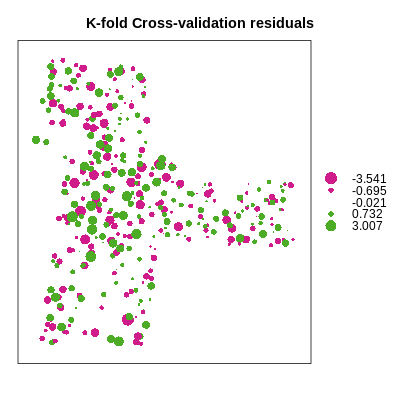

In [18]:
%%R -w 400 -h 400 -u px
bubble(cv, zcol = "residual", maxsize = 2.0,  main = "K-fold Cross-validation residuals")

### Evaluation Matrix

In [19]:
%%R
# Mean Error (ME)
ME<-round(mean(cv$residual),3)
# Mean Absolute Error
MAE<-round(mean(abs(cv$residual)),3)
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(cv$residual^2)),3)
# Mean Squared Deviation Ratio (MSDR)
MSDR<-mean(cv$residual^2/cv$var1.var)



In [20]:
%%R
RMSE

[1] 1.069


### Plot Observed vs Predicted values

`geom_smooth()` using formula = 'y ~ x'


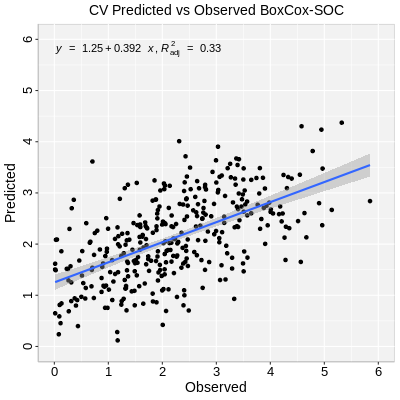

In [21]:
%%R -w 400 -h 400 -u px

cv.df<-as.data.frame(cv)

formula<-y~x

ggplot(cv.df, aes(observed,var1.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("CV Predicted vs Observed BoxCox-SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Validation with an test Data Set**

In [22]:
%%R
val<-krige(SOC.bc ~ x+y,
         loc=train.xy,        # train data
         newdata=test.xy,         # test data
         model = vm.bc.r)

[using universal kriging]


In [ ]:
%%R
summary(val)

Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1186067   70606.76
y  1038971 2502087.41
Is projected: NA 
proj4string : [NA]
Number of points: 101
Data attributes:
   var1.pred        var1.var     
 Min.   :0.203   Min.   :0.5069  
 1st Qu.:1.437   1st Qu.:0.9860  
 Median :1.883   Median :1.1830  
 Mean   :2.051   Mean   :1.1203  
 3rd Qu.:2.682   3rd Qu.:1.2837  
 Max.   :4.290   Max.   :1.4943  


###  Residuals

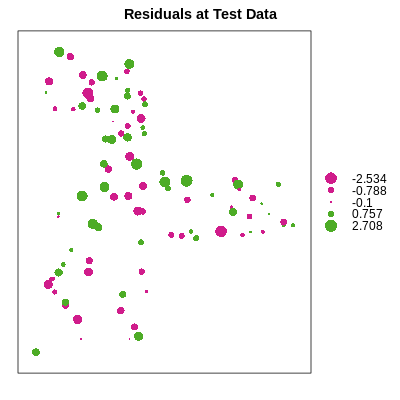

In [24]:
%%R -w 400 -h 400 -u px
test.xy$SOC.pred<-val$var1.pred
test.xy$SOC.var<-val$var1.var
test.xy$residual<-(test.xy$SOC.bc-test.xy$SOC.pred)
bubble(test.xy, zcol = "residual", maxsize = 2.0,  main = "Residuals at Test Data")

In [26]:
%%R
# Mean Error (ME)
ME<-round(mean(test.xy$residual),3)
# Mean Absolute Error
MAE<-round(mean(abs(test.xy$residual)),3)
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(test.xy$residual^2)),3)
RMSE

[1] 1.118


`geom_smooth()` using formula = 'y ~ x'


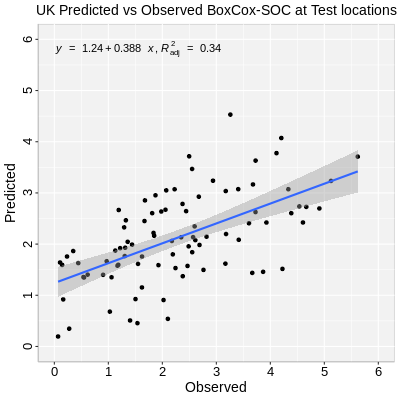

In [27]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test.xy)

formula<-y~x

ggplot(test.df, aes(SOC.bc,SOC.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("UK Predicted vs Observed BoxCox-SOC at Test locations") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **UK Kriging Prediction**

We can use the krige() function with one additional argument: **block**, which gives the block's dimensions as a list. For the usual case of a 2D block (surface area), this is a list of two dimensions (usually, but not necessarily the same). We will use formula SOC.bc ~ x+y as opposed to SOC.bc ~ 1 in the OK.

In [28]:
%%R
UK <- krige(SOC.bc ~ x+y,
                 loc =  train.xy,
                 newdata = grid.xy,
                 model = vm.bc.r,
                 block = c(50000, 50000)) # 50 km x 50 km

[using universal kriging]


### Back transformation

In [30]:
%%R
# Back transformation
k<-1/lambda
UK$UK.pred <-((UK$var1.pred *lambda+1)^k)
UK$UK.var <-((UK$var1.var *lambda+1)^k)


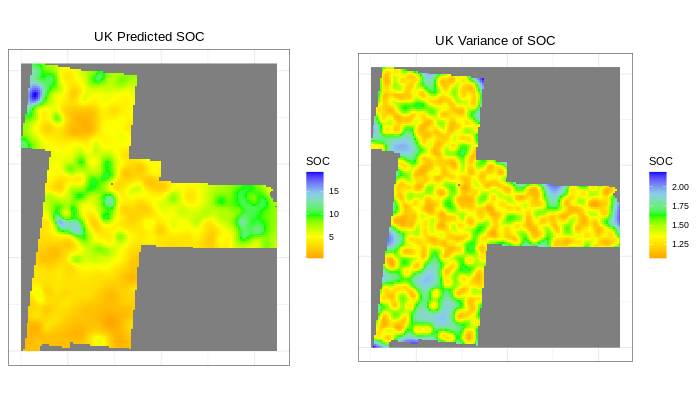

In [31]:
%%R -w 700 -h 400 -u px

UK.pred<-rasterFromXYZ(as.data.frame(UK)[, c("x", "y", "UK.pred")])
UK.var<-rasterFromXYZ(as.data.frame(UK)[, c("x", "y", "UK.var")])

# Predicted SOC
p3<-ggR(UK.pred, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("UK Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

# Error
p4<-ggR(UK.var, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("UK Variance of SOC")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p3,p4, ncol = 2)  # Multiplot

### Further Reading

1. [Understanding universal kriging](https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/understanding-universal-kriging.htm)

2. [What You Need About Universal Kriging: A Complete Guide](https://giscourse.online/what-you-need-about-universal-kriging-a-complete-guide/)

3. [Spatial interpolation in R](https://pages.cms.hu-berlin.de/EOL/gcg_quantitative-methods/Lab14_Kriging.html#Sample_variogram)